# Question Type Classification Models: (S)TF-IDF + XGBoost Experiments
#### Multilingual Question Type Classification and Complexity Prediction

##### Author: Robin Kokot
##### Date: March 2025


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Setup and Data Loading

In [2]:
!pip install -q wandb
!pip install -q datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from scipy.sparse import vstack
from datasets import load_dataset
import wandb
import logging
import time
import os

# ==================== directories
models_dir = "/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments/models"
os.makedirs(models_dir, exist_ok=True)
figures_dir = "/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments/models"
os.makedirs(figures_dir, exist_ok=True)

# ==================== Set up displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)

# ==================== Set up seed constant
SEED = 69
np.random.seed(SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12

In [3]:
# ==================== Wandb config
run = wandb.init(project="MAIthesis", name="xgboost-clf-baseline", tags=["baseline", "xgboost", "question-classification", "tfidf"], job_type="model-training", dir="/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments/")

config = wandb.config
config.max_depth = 6
config.learning_rate = 0.3
config.n_estimators = 100
config.objective = 'binary:logistic'
config.random_state = 69
config.subsample = 0.8
config.colsample_bytree = 0.8
config.eval_metric='error'


wandb.run.notes = "Baseline experiments with polar vs. content question type classification using XGBoost classifier on subword TF-IDF vectors"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rokii (rokii-ku-leuven) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
# ==================== Dataset loading and label config
dataset = load_dataset("rokokot/question-type-and-complexity-v2")

y_train = np.array(dataset['train']['question_type'])
y_dev = np.array(dataset['validation']['question_type'])
y_test= np.array(dataset['test']['question_type'])

print(f"Train label distribution: {np.bincount(y_train)}")
print(f"Test label distribution: {np.bincount(y_test)}")
print(f"Validation label distribution: {np.bincount(y_dev)}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.0k [00:00<?, ?B/s]

tydi_train_base.csv:   0%|          | 0.00/885k [00:00<?, ?B/s]

dev_base.csv:   0%|          | 0.00/57.4k [00:00<?, ?B/s]

ud_test_base.csv:   0%|          | 0.00/97.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/441 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/719 [00:00<?, ? examples/s]

Train label distribution: [3778 3682]
Test label distribution: [367 352]
Validation label distribution: [223 218]


In [5]:
# ==================== TFIDF vectors loading
train_vectors = "/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/vectors/tfidf_vectors_train.pkl"
dev_vectors = "/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/vectors/tfidf_vectors_dev.pkl"
test_vectors = "/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/vectors/tfidf_vectors_test.pkl"

with open(train_vectors, 'rb') as v:
  X_train = pickle.load(v)
with open(dev_vectors, 'rb') as v:
  X_dev = pickle.load(v)
with open(test_vectors, 'rb') as v:
  X_test = pickle.load(v)

print("\nchecking shapes of features and labels:")
print(f"Train - Features: {X_train.shape[0]}, Labels: {y_train.shape[0]}")
print(f"Test - Features: {X_test.shape[0]}, Labels: {y_test.shape[0]}")
print(f"Validation - Features: {X_dev.shape[0]}, Labels: {y_dev.shape[0]}")


checking shapes of features and labels:
Train - Features: 7460, Labels: 7460
Test - Features: 719, Labels: 719
Validation - Features: 441, Labels: 441


In [6]:
# ====================== Helper functions for data formatting
sparse_matrices = [matrix[0] for matrix in X_train]
X_train_stacked = vstack(sparse_matrices)

sparse_matrices = [matrix[0] for matrix in X_dev]
X_dev_stacked = vstack(sparse_matrices)

sparse_matrices_test = [matrix[0] for matrix in X_test]
X_test_stacked = vstack(sparse_matrices_test)

## XGBoost baseline classifier setup

In [7]:
# ==================== XGBoost config with TFIDF vectors
xgb_clf = xgb.XGBClassifier(
    max_depth=config.max_depth,
    learning_rate=config.learning_rate,
    n_estimators=config.n_estimators,
    objective=config.objective,
    random_state=config.random_state,
    subsample=config.subsample,
    colsample_bytree=config.colsample_bytree,
    eval_metric=config.eval_metric
)

wandb.config.update({
  "model_type": "XGBoost",
  "feature_type": "TF-IDF",
  "train_samples": X_train_stacked.shape[0],
  "test_samples": X_test_stacked.shape[0],
  "dev_samples": X_dev_stacked.shape[0],
  "feature_dim": X_train_stacked.shape[1]
})

In [8]:
# ==================== Train the model with real labels
start_time = time.time()

xgb_clf.fit(X_train_stacked, y_train, eval_set=[(X_train_stacked, y_train), (X_dev_stacked, y_dev)], verbose=50)

training_time = time.time() - start_time
print(f"training took {training_time:.2f} seconds")
wandb.log({"training_time": training_time})

[0]	validation_0-error:0.26233	validation_1-error:0.31293
[50]	validation_0-error:0.03338	validation_1-error:0.14739
[99]	validation_0-error:0.01609	validation_1-error:0.12245
training took 64.68 seconds


Dev Set: Accuracy = 0.8776, F1 Score = 0.8773
Confusion Matrix (Dev Set):
[[194  29]
 [ 25 193]]


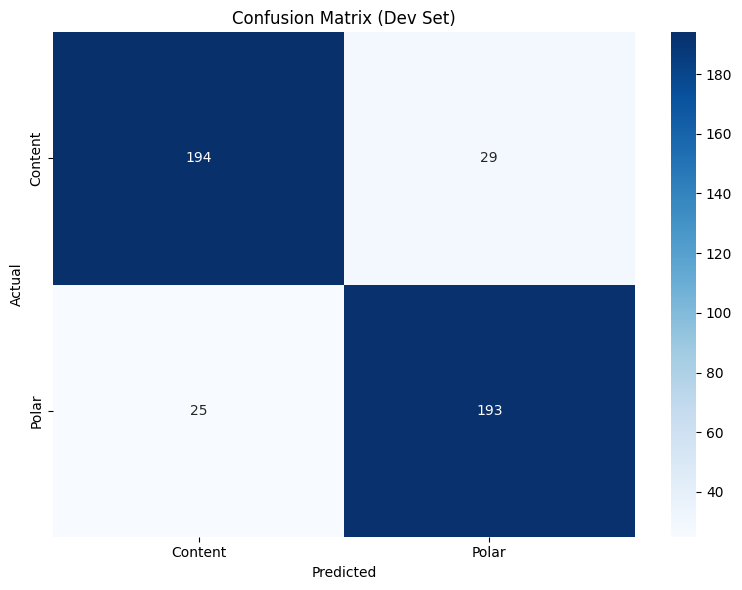

In [9]:
# ==================== Model evaluation - Dev set
y_pred_dev = xgb_clf.predict(X_dev_stacked)
y_pred_proba_dev = xgb_clf.predict_proba(X_dev_stacked)[:, 1]

accuracy_dev = accuracy_score(y_dev, y_pred_dev)
precision_dev, recall_dev, f1_dev, _ = precision_recall_fscore_support(y_dev, y_pred_proba_dev > 0.5, average='binary')

print(f"Dev Set: Accuracy = {accuracy_dev:.4f}, F1 Score = {f1_dev:.4f}")

cm_dev = confusion_matrix(y_dev, y_pred_dev)
print("Confusion Matrix (Dev Set):")
print(cm_dev)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues',xticklabels=['Content', 'Polar'],  yticklabels=['Content', 'Polar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Dev Set)')
plt.tight_layout()

wandb.log({"dev_accuracy": accuracy_dev, "dev_precision": precision_dev, "dev_recall":recall_dev, "dev_f1": f1_dev})
wandb.log({"dev_confusion_matrix": wandb.Image(plt)})

Test Set: Accuracy = 0.7761, F1 Score = 0.7895
Confusion Matrix (Test Set):
[[256 111]
 [ 50 302]]


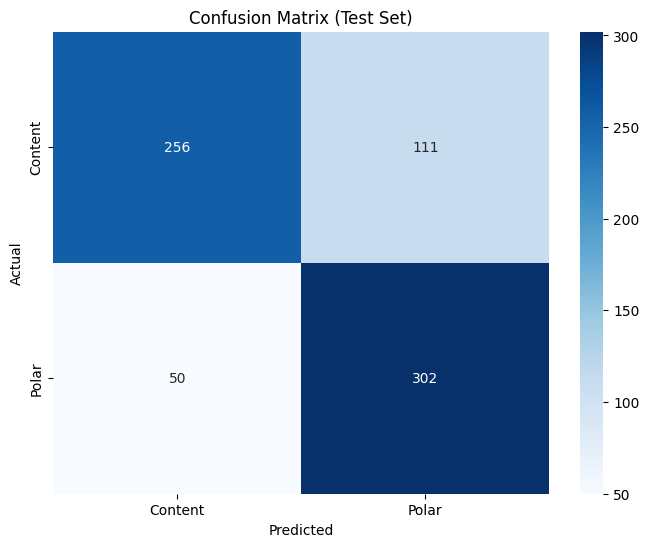

In [10]:
# ==================== Evaluation - Test set
y_pred_test = xgb_clf.predict(X_test_stacked)
y_pred_proba_test = xgb_clf.predict_proba(X_test_stacked)[:, 1]

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_proba_test > 0.5, average='binary')
print(f"Test Set: Accuracy = {accuracy_test:.4f}, F1 Score = {f1_test:.4f}")

cm_test = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix (Test Set):")
print(cm_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Content', 'Polar'], yticklabels=['Content', 'Polar'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout

wandb.log({"test_accuracy": accuracy_test,"test_precision": precision_test,"test_recall": recall_test,"test_f1": f1_test})
wandb.log({"test_confusion_matrix": wandb.Image(plt)})

Top 50 important features:
       feature_index  importance
86932          86932    0.037190
14529          14529    0.036031
1779            1779    0.033070
545              545    0.027282
1996            1996    0.027063
...              ...         ...
100              100    0.005909
8                  8    0.005837
347              347    0.005817
2616            2616    0.005601
2596            2596    0.005521

[50 rows x 2 columns]


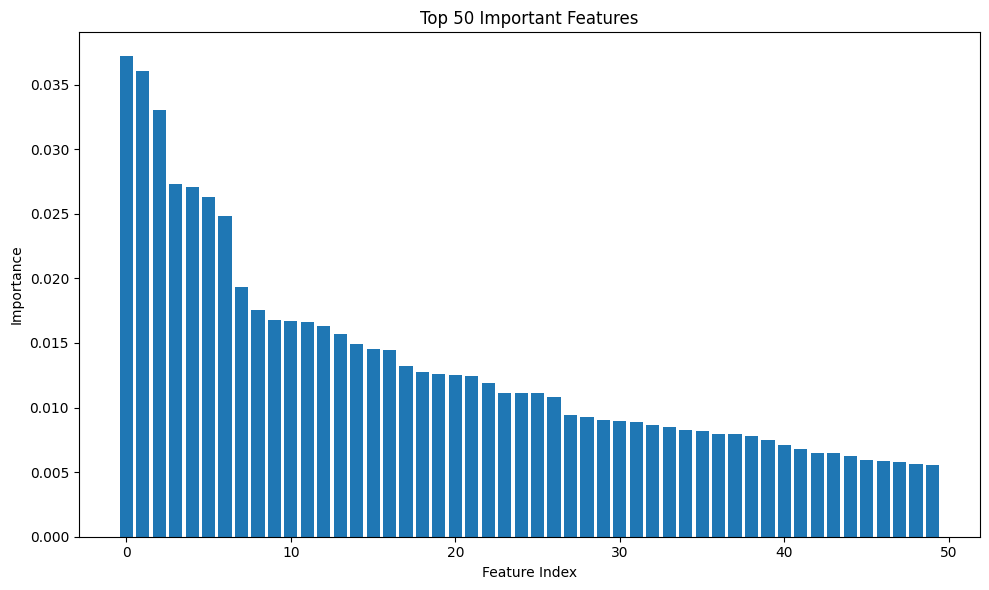

In [11]:
# ==================== Feature importance extraction
importance = xgb_clf.feature_importances_
feature_importance_df = pd.DataFrame({'feature_index': range(len(importance)),'importance': importance}).sort_values('importance',ascending=False)

top_features = feature_importance_df.head(50)
print("Top 50 important features:")
print(top_features)

plt.figure(figsize=(10, 6))
plt.bar(range(50), top_features['importance'])
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 50 Important Features')
plt.tight_layout()

wandb.log({"feature_importance": wandb.Image(plt)})
wandb.log({"feature_importance_table": wandb.Table(data=[[int(idx), float(imp)] for idx, imp in zip(top_features['feature_index'], top_features['importance'])],columns=["feature_index", "importance"])})

In [12]:
# ==================== Load the token to index map for interpretation of the features
with open('/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/vectors/token_to_index_mapping.pkl', 'rb') as f:
    token_to_index = pickle.load(f)
with open('/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/vectors/idf_values.pkl', 'rb') as f:
    idf_values = pickle.load(f)

index_to_token = {idx: token for token, idx in token_to_index.items()}

top_indices = [86932, 14529, 1779, 545, 1996, 12432, 47503, 24, 177, 45841, 9007, 66274, 149, 67398, 121905, 121905, 1513, 16990, 3018, 117] # to do: fix this

top_features = []
for idx in top_indices:
    token = index_to_token.get(idx, f"Unknown-{idx}")
    idf = idf_values.get(idx, 0) if isinstance(idf_values, dict) else 0
    top_features.append((token, idx, idf))

print("Top tokens by importance:")
print("Token\t\tIndex\tIDF Value")
print("-" * 40)
for token, idx, idf in top_features:
    token_str = token if len(str(token)) < 8 else f"{token[:7]}..."
    print(f"{token_str:15} {idx:6d} {idf:.4f}")

Top tokens by importance:
Token		Index	IDF Value
----------------------------------------
▁Onko            86932 0.0000
▁هل              14529 0.0000
▁ли               1779 0.0000
は                  545 0.0000
▁Is               1996 0.0000
初                12432 0.0000
▁Apakah          47503 0.0000
?                   24 0.3069
▁O                 177 0.0000
▁apakah          45841 0.0000
何                 9007 0.0000
▁What            66274 0.0000
▁on                149 0.0000
인가               67398 0.0000
▁Does           121905 0.0000
▁Does           121905 0.0000
▁was              1513 0.0000
▁Mill            16990 0.0000
▁Do               3018 0.0000
▁is                117 0.3069


In [14]:
# ==================== Save Model
model_path = '/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments/models/xgboost_clf_model.json'
xgb_clf.save_model(model_path)

wandb.save(model_path)

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/content/wandb/run-20250325_141753-n6y8pm1u/files/models/xgboost_clf_model.json']

## XGBoost with control labels


In [ ]:
# ==================== XGBoost config with TFIDF vectors in a loop over destroyed labels

def train_destroyed_label(seed, y_train_destroyed):

    wandb.init(
        project="MAIthesis",
        name=f"xgboost-destroyed-seed-{seed}",
        tags=["baseline", "xgboost", "control-labels"],
        job_type="model-training",
        reinit=True
    )

    config = wandb.config
    config.max_depth = 6
    config.learning_rate = 0.3
    config.n_estimators = 100
    config.objective = 'binary:logistic'
    config.random_state = 69
    config.subsample = 0.8
    config.colsample_bytree = 0.8
    config.eval_metric = 'error'

    wandb.config.update({
        "model_type": "XGBoost",
        "feature_type": "TF-IDF",
        "label_type": f"destroyed-seed-{seed}",
        "train_samples": X_train_stacked.shape[0],
        "test_samples": X_test_stacked.shape[0],
        "dev_samples": X_dev_stacked.shape[0],
        "feature_dim": X_train_stacked.shape[1]
    })

    xgb_clf = xgb.XGBClassifier(
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        objective=config.objective,
        random_state=config.random_state,
        subsample=config.subsample,
        colsample_bytree=config.colsample_bytree,
        eval_metric=config.eval_metric
    )

    start_time = time.time()
    xgb_clf.fit(
        X_train_stacked, y_train_destroyed,
        eval_set=[(X_train_stacked, y_train_destroyed), (X_dev_stacked, y_dev)],
        verbose=50
    )
    training_time = time.time() - start_time
    print(f"Training took {training_time:.2f} seconds")
    wandb.log({"training_time": training_time})

    # ==================== Evaluate on dev set (real labels)
    y_pred_dev = xgb_clf.predict(X_dev_stacked)
    y_pred_proba_dev = xgb_clf.predict_proba(X_dev_stacked)[:, 1]
    accuracy_dev = accuracy_score(y_dev, y_pred_dev)
    precision_dev, recall_dev, f1_dev, _ = precision_recall_fscore_support(y_dev, y_pred_proba_dev > 0.5, average='binary')

    print(f"Dev Set: Accuracy = {accuracy_dev:.4f}, F1 Score = {f1_dev:.4f}")

    cm_dev = confusion_matrix(y_dev, y_pred_dev)
    print("Confusion Matrix (Dev Set):")
    print(cm_dev)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_dev, annot=True, fmt='d', cmap='Blues',xticklabels=['Content', 'Polar'],yticklabels=['Content', 'Polar'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Dev Set (Destroyed Seed {seed})')
    plt.tight_layout()

    wandb.log({"dev_accuracy": accuracy_dev,"dev_precision": precision_dev,"dev_recall": recall_dev,"dev_f1": f1_dev})
    wandb.log({"dev_confusion_matrix": wandb.Image(plt)})

    # ==================== Evaluate on test set (real labels)
    y_pred_test = xgb_clf.predict(X_test_stacked)
    y_pred_proba_test = xgb_clf.predict_proba(X_test_stacked)[:, 1]

    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(y_test, y_pred_proba_test > 0.5, average='binary')

    print(f"Test Set: Accuracy = {accuracy_test:.4f}, F1 Score = {f1_test:.4f}")

    cm_test = confusion_matrix(y_test, y_pred_test)
    print("Confusion Matrix (Test Set):")
    print(cm_test)


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',xticklabels=['Content', 'Polar'],yticklabels=['Content', 'Polar'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Test Set (Destroyed Seed {seed})')
    plt.tight_layout()

    wandb.log({"test_accuracy": accuracy_test,"test_precision": precision_test,"test_recall": recall_test,"test_f1": f1_test})
    wandb.log({"test_confusion_matrix": wandb.Image(plt)})

    model_path = f'/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments/models/xgboost_clf_destroyed_seed_{seed}_model.json'
    xgb_clf.save_model(model_path)
    wandb.save(model_path)


    return {'model': xgb_clf,'metrics': {'dev_accuracy': accuracy_dev,'dev_f1': f1_dev,'test_accuracy': accuracy_test,'test_f1': f1_test}}


[0]	validation_0-error:0.49035	validation_1-error:0.51020
[50]	validation_0-error:0.33365	validation_1-error:0.51247
[99]	validation_0-error:0.27131	validation_1-error:0.48526
Training took 62.48 seconds
Dev Set: Accuracy = 0.5147, F1 Score = 0.4427
Confusion Matrix (Dev Set):
[[142  81]
 [133  85]]
Test Set: Accuracy = 0.5090, F1 Score = 0.4087
Confusion Matrix (Test Set):
[[244 123]
 [230 122]]


dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.51474
dev_f1,0.44271


[0]	validation_0-error:0.48713	validation_1-error:0.49660
[50]	validation_0-error:0.32909	validation_1-error:0.54422
[99]	validation_0-error:0.27279	validation_1-error:0.50340
Training took 66.55 seconds
Dev Set: Accuracy = 0.4966, F1 Score = 0.4861
Confusion Matrix (Dev Set):
[[114 109]
 [113 105]]
Test Set: Accuracy = 0.4854, F1 Score = 0.4875
Confusion Matrix (Test Set):
[[173 194]
 [176 176]]


dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.4966
dev_f1,0.48611


[0]	validation_0-error:0.47989	validation_1-error:0.50567
[50]	validation_0-error:0.32225	validation_1-error:0.44671
[99]	validation_0-error:0.26783	validation_1-error:0.43537
Training took 63.02 seconds
Dev Set: Accuracy = 0.5646, F1 Score = 0.5248
Confusion Matrix (Dev Set):
[[143  80]
 [112 106]]
Test Set: Accuracy = 0.5118, F1 Score = 0.4641
Confusion Matrix (Test Set):
[[216 151]
 [200 152]]


dev_accuracy,▁
dev_f1,▁
dev_precision,▁
dev_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
training_time,▁
dev_accuracy,0.56463
dev_f1,0.52475



Comparison results saved to /content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments/models and /content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments/models


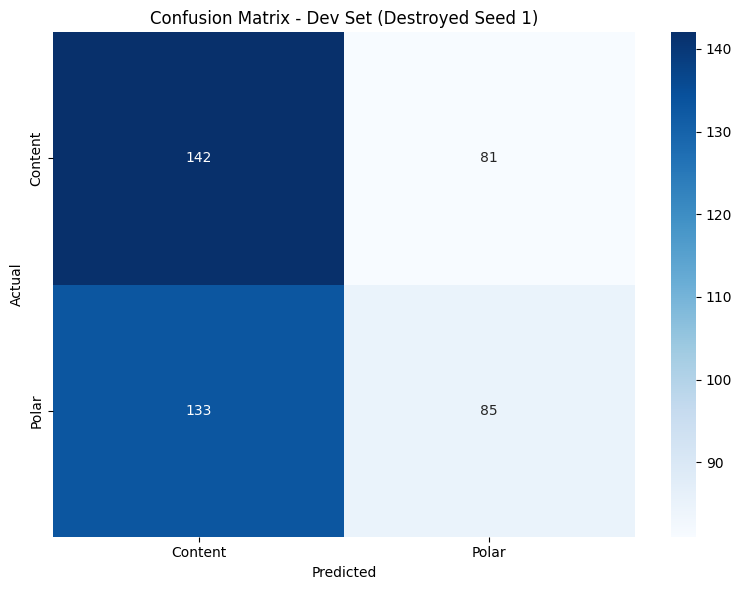

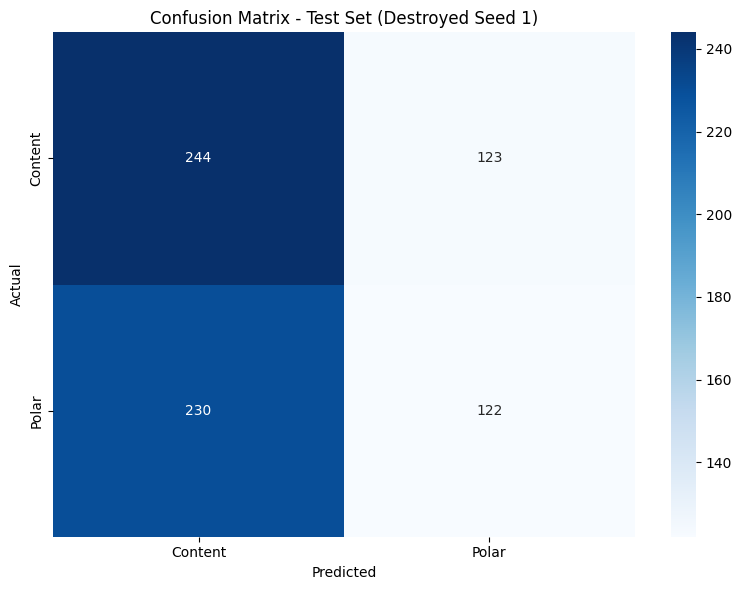

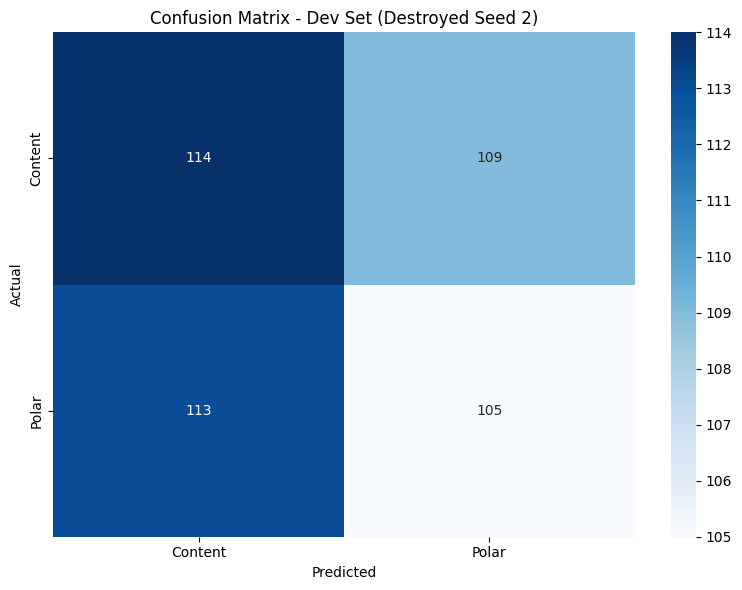

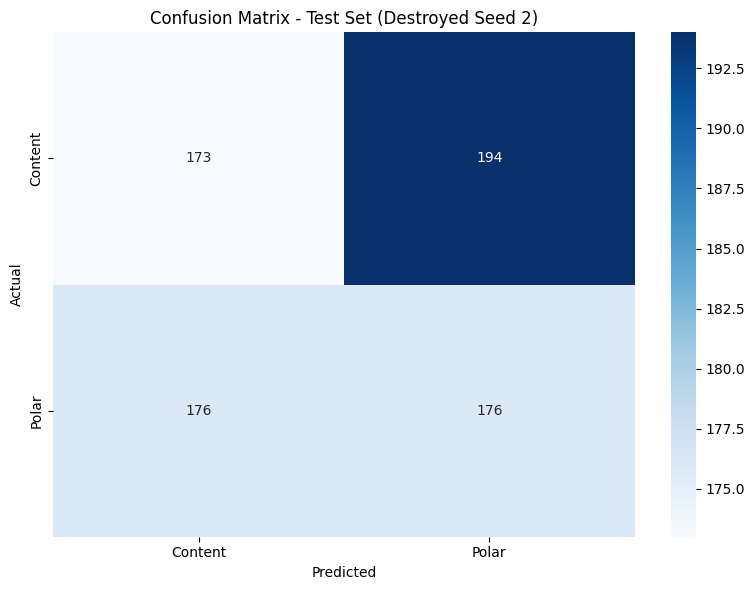

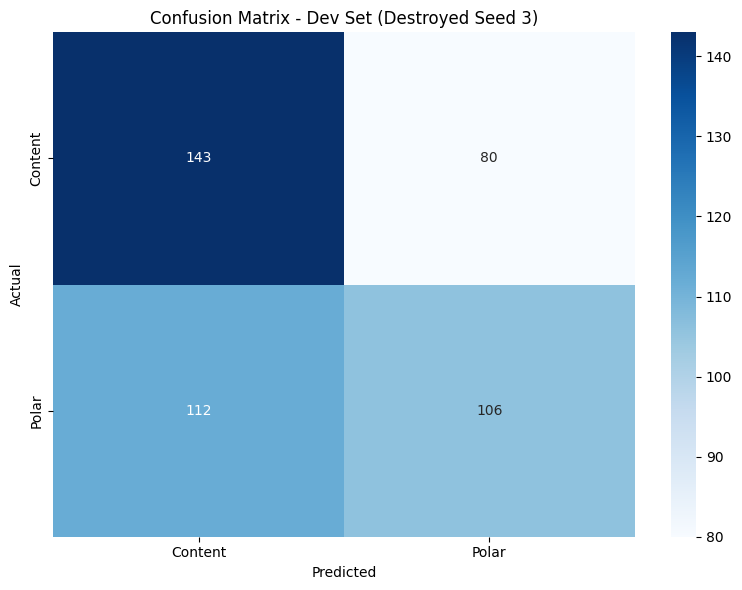

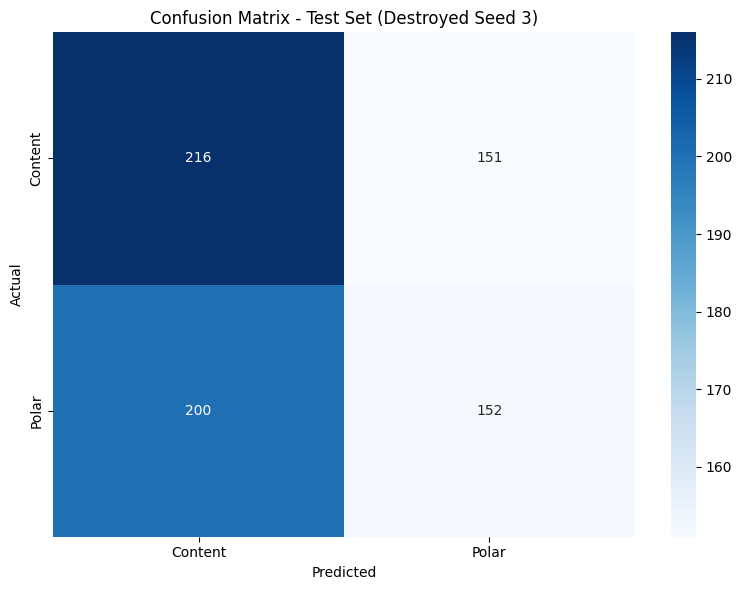

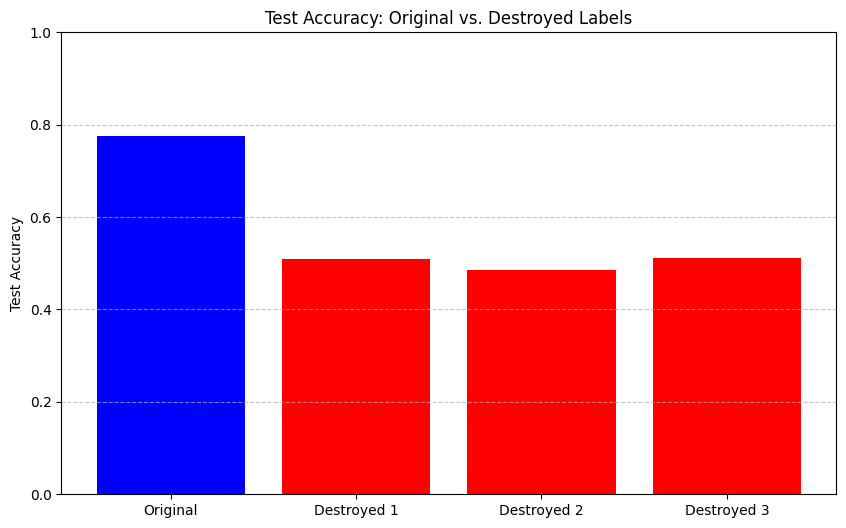

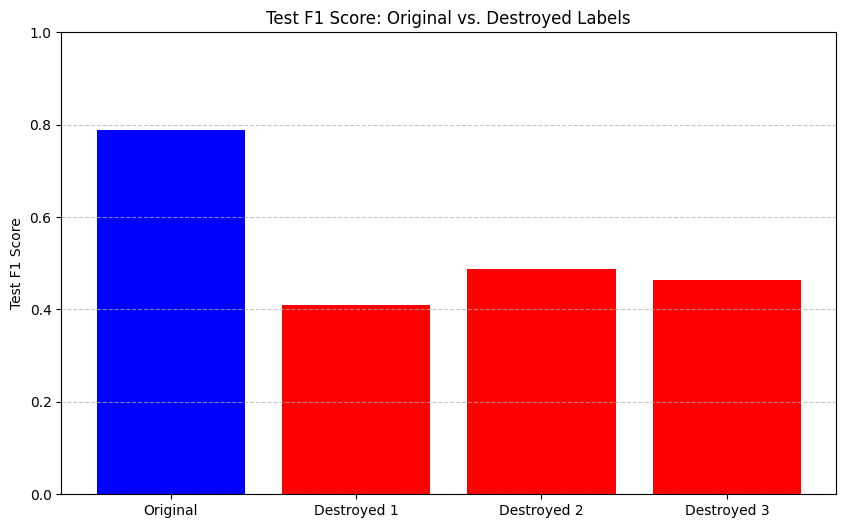

In [29]:
# ==================== Run the training loop for destroyed sets
results = {}
for seed in [1, 2, 3]:
    destroyed_path = f"/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/data/destroyed/destroyed_types/question_type_destroyed_seed_{seed}.csv"
    destroyed_df = pd.read_csv(destroyed_path)
    y_train_destroyed = np.array(destroyed_df['question_type_destroyed'])
    result = train_destroyed_label(seed, y_train_destroyed)
    results[seed] = result

wandb.init(project="MAIthesis",name="xgboost-destroyed-comparison",tags=["baseline", "xgboost", "comparison"],job_type="analysis", dir="/content/drive/MyDrive/ColabNotebooks/colabMAIbaselines/experiments")


# =================== Plot performance stats for destroyed models on test labels
plt.figure(figsize=(10, 6))
models = ['Original'] + [f'Destroyed {seed}' for seed in [1, 2, 3]]
test_accuracies = [accuracy_test] + [results[seed]['metrics']['test_accuracy'] for seed in [1, 2, 3]]

plt.bar(models, test_accuracies, color=['blue'] + ['red']*3)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy: Original vs. Destroyed Labels')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

comparison_path = os.path.join(figures_dir, "test_accuracy_comparison.png")
plt.savefig(comparison_path)
wandb.log({"test_accuracy_comparison": wandb.Image(plt)})

plt.figure(figsize=(10, 6))
f1_scores = [f1_test] + [results[seed]['metrics']['test_f1'] for seed in [1, 2, 3]]

plt.bar(models, f1_scores, color=['blue'] + ['red']*3)
plt.ylabel('Test F1 Score')
plt.title('Test F1 Score: Original vs. Destroyed Labels')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

f1_comparison_path = os.path.join(figures_dir, "test_f1_comparison.png")
plt.savefig(f1_comparison_path)
wandb.log({"test_f1_comparison": wandb.Image(plt)})

comparison_metrics = {"original": {"dev_accuracy": float(accuracy_dev),"dev_f1": float(f1_dev),"test_accuracy": float(accuracy_test),"test_f1": float(f1_test)}}

for seed in [1, 2, 3]:
    comparison_metrics[f"destroyed_seed_{seed}"] = results[seed]['metrics']

combined_metrics_path = os.path.join(models_dir, "comparison_metrics.json")
with open(combined_metrics_path, 'w') as f:
    json.dump(comparison_metrics, f, indent=4)

comparison_table = wandb.Table(columns=["Model", "Test Accuracy", "Test F1"])
comparison_table.add_data("Original", accuracy_test, f1_test)

for seed in [1, 2, 3]:
    metrics = results[seed]['metrics']
    comparison_table.add_data(f"Destroyed {seed}", metrics['test_accuracy'],metrics['test_f1'])

wandb.log({"metrics_comparison": comparison_table})

print(f"\nComparison results saved to {models_dir} and {figures_dir}")



### Language specific performance analysis


Analyzing performance by language...
ar: 77 samples, Baseline acc=0.9870
en: 110 samples, Baseline acc=0.7818
fi: 110 samples, Baseline acc=0.8364
id: 110 samples, Baseline acc=0.6364
ja: 92 samples, Baseline acc=0.6848
ko: 110 samples, Baseline acc=0.7545
ru: 110 samples, Baseline acc=0.8000


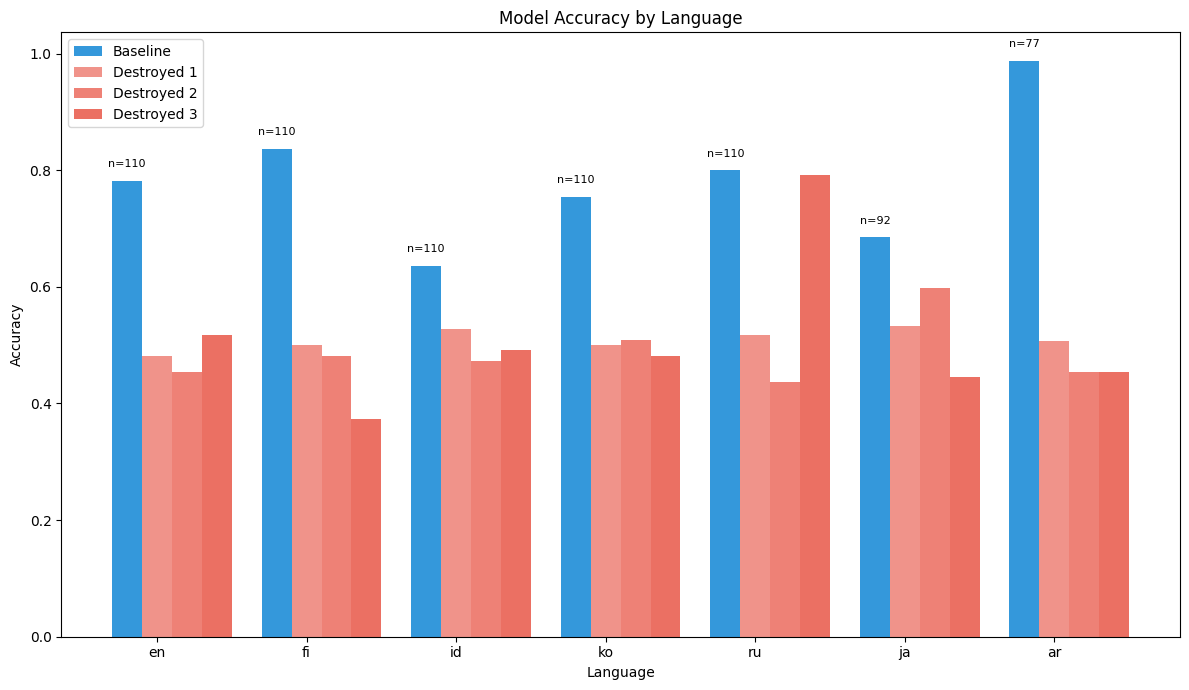

In [21]:
# ==================== Analyze performance by language
def analyze_language_performance():
    print("\nAnalyzing performance by language...")

    language_data = dataset['test']['language']
    languages = sorted(list(set(language_data)))

    # Store results for baseline and destroyed models
    language_results = {}

    # Calculate metrics for each language
    for lang in languages:
        # Create mask for this language
        lang_mask = [x == lang for x in language_data]
        lang_indices = [i for i, x in enumerate(lang_mask) if x]

        # Skip if not enough samples
        if len(lang_indices) < 10:
            continue

        # Get test data for this language
        X_test_lang = X_test_stacked[lang_indices]
        y_test_lang = y_test[lang_indices]

        # Calculate baseline model performance
        y_pred_baseline = xgb_clf.predict(X_test_lang)
        accuracy_baseline = accuracy_score(y_test_lang, y_pred_baseline)
        _, _, f1_baseline, _ = precision_recall_fscore_support(
            y_test_lang, y_pred_baseline, average='binary'
        )

        # Store baseline results
        language_results[lang] = {
            'samples': len(y_test_lang),
            'baseline': {
                'accuracy': accuracy_baseline,
                'f1': f1_baseline
            },
            'destroyed': {}
        }

        # Calculate performance for each destroyed model
        for seed in [1, 2, 3]:
            if seed in results:
                destroyed_model = results[seed]['model']
                y_pred_destroyed = destroyed_model.predict(X_test_lang)

                accuracy_destroyed = accuracy_score(y_test_lang, y_pred_destroyed)
                _, _, f1_destroyed, _ = precision_recall_fscore_support(
                    y_test_lang, y_pred_destroyed, average='binary'
                )

                # Store destroyed model results
                language_results[lang]['destroyed'][seed] = {
                    'accuracy': accuracy_destroyed,
                    'f1': f1_destroyed
                }

        print(f"{lang}: {language_results[lang]['samples']} samples, Baseline acc={accuracy_baseline:.4f}")

    # Filter and sort languages by sample size
    valid_languages = [(lang, info['samples']) for lang, info in language_results.items()]
    valid_languages.sort(key=lambda x: x[1], reverse=True)
    languages_ordered = [lang for lang, _ in valid_languages]

    # Create visualization for top 10 languages
    top_languages = languages_ordered[:10]

    plt.figure(figsize=(12, 7))

    # Set up for grouped bar chart
    bar_width = 0.2
    index = np.arange(len(top_languages))

    # Plot baseline accuracy
    baseline_acc = [language_results[lang]['baseline']['accuracy'] for lang in top_languages]
    plt.bar(index, baseline_acc, bar_width, label='Baseline', color='#3498db')

    # Plot destroyed models accuracy
    for i, seed in enumerate([1, 2, 3]):
        if any(seed in language_results[lang]['destroyed'] for lang in top_languages):
            destroyed_acc = [
                language_results[lang]['destroyed'].get(seed, {}).get('accuracy', 0)
                for lang in top_languages
            ]
            plt.bar(index + (i+1)*bar_width, destroyed_acc, bar_width,
                    label=f'Destroyed {seed}', color=f'#e74c3c', alpha=0.6+i*0.1)

    # Add details to plot
    plt.xlabel('Language')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Language')
    plt.xticks(index + bar_width, top_languages)
    plt.legend()

    # Add sample size above bars
    for i, lang in enumerate(top_languages):
        plt.text(i, baseline_acc[i] + 0.02, f"n={language_results[lang]['samples']}",
                ha='center', va='bottom', fontsize=8)

    plt.tight_layout()

    # Log to wandb
    wandb.log({"language_accuracy": wandb.Image(plt)})

    # Create summary table
    table_data = []
    for lang in languages_ordered:
        info = language_results[lang]
        row = [
            lang,
            info['samples'],
            info['baseline']['accuracy'],
            info['baseline']['f1']
        ]
        for seed in [1, 2, 3]:
            if seed in info['destroyed']:
                row.extend([
                    info['destroyed'][seed]['accuracy'],
                    info['destroyed'][seed]['f1']
                ])
            else:
                row.extend([None, None])
        table_data.append(row)

    # Log table to wandb
    columns = ["Language", "Samples", "Baseline Acc", "Baseline F1"]
    for seed in [1, 2, 3]:
        columns.extend([f"Destroyed {seed} Acc", f"Destroyed {seed} F1"])

    wandb.log({
        "language_metrics": wandb.Table(columns=columns, data=table_data)
    })

    return language_results, languages_ordered

# Run the analysis
language_results, languages_ordered = analyze_language_performance()


Generating confusion matrices by language...
Generated confusion matrices and sensitivity analysis for 4 languages


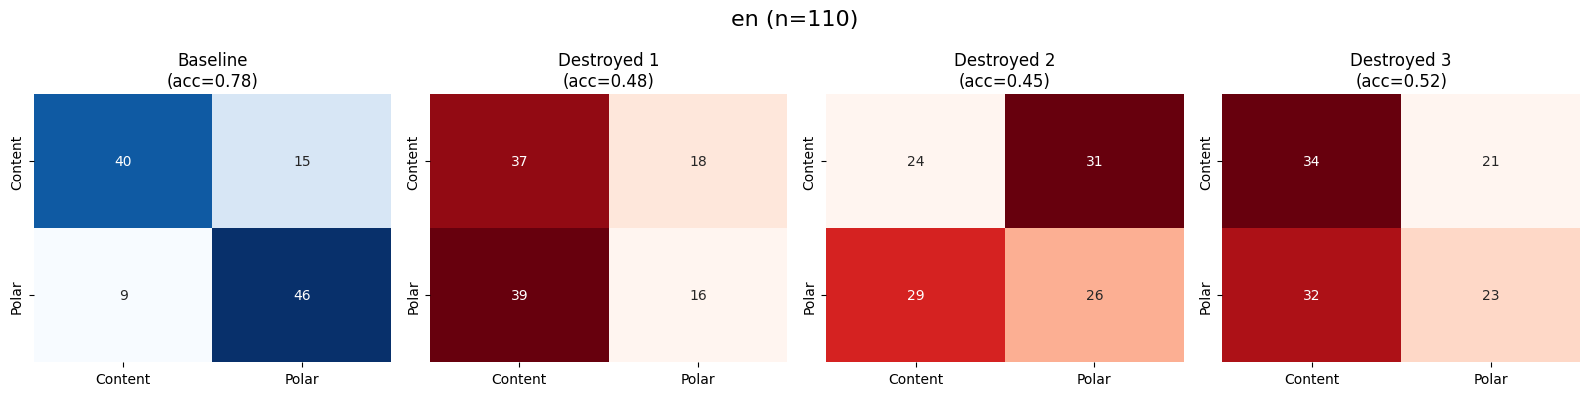

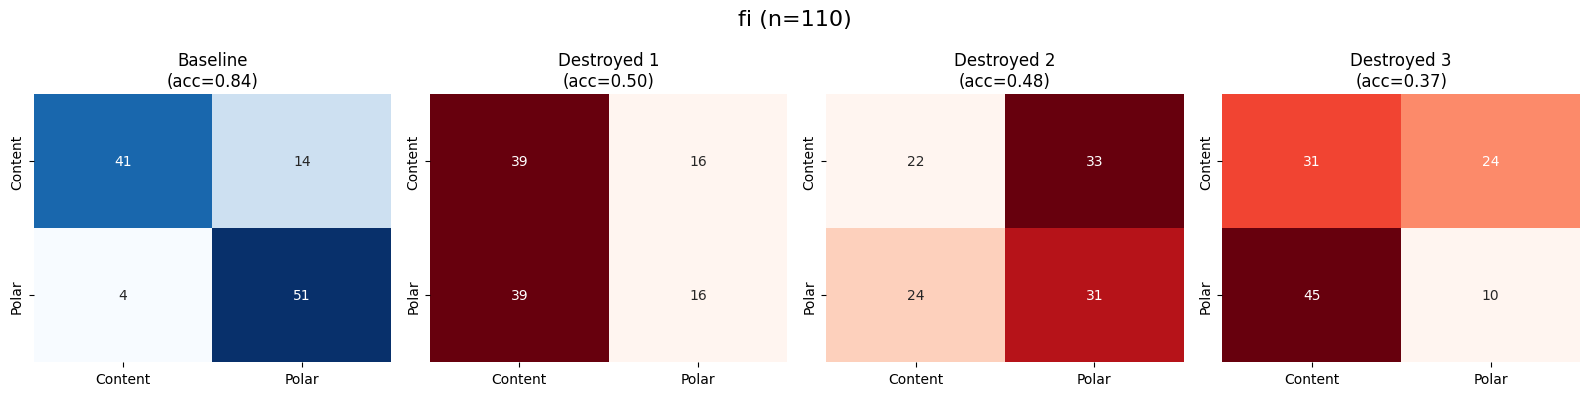

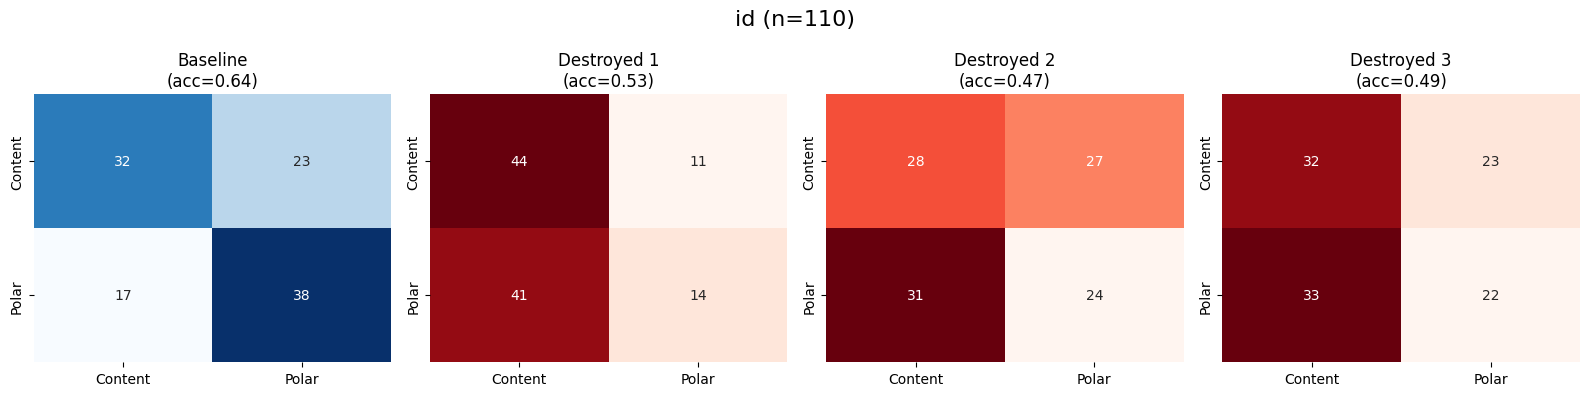

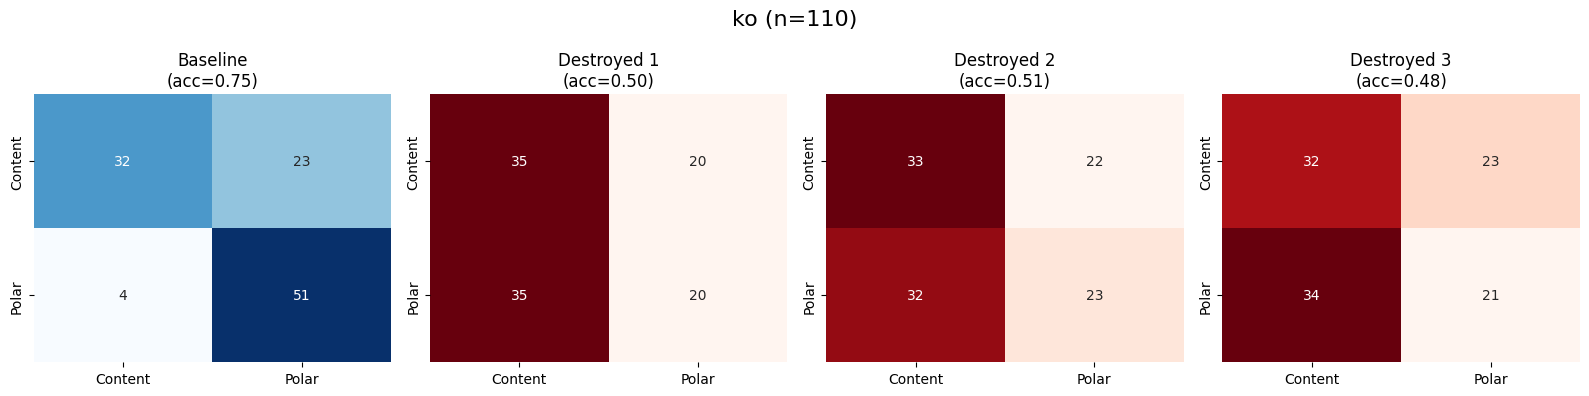

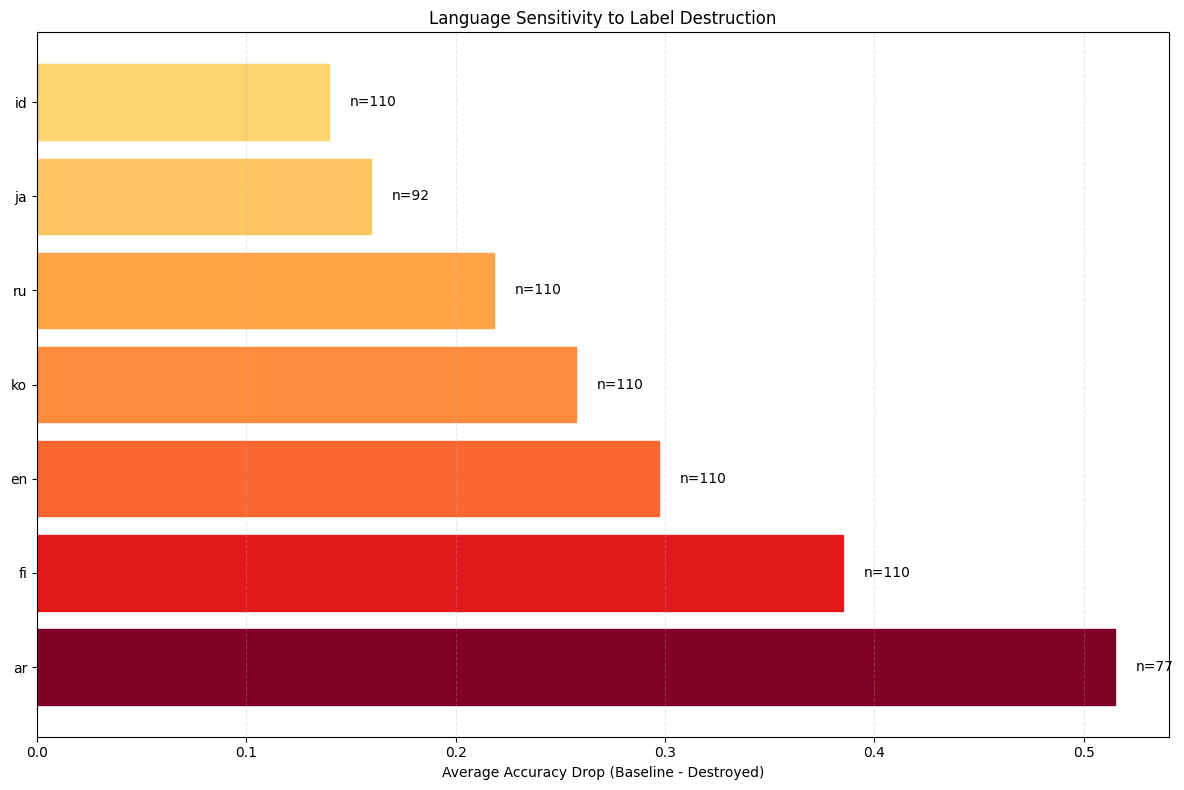

In [23]:
# ==================== Generate confusion matrices by language
def create_language_confusion_matrices(language_results, languages_ordered):
    print("\nGenerating confusion matrices by language...")

    # Get language information
    language_data = dataset['test']['language']

    # Choose top languages by sample size (limit to 4 for clarity)
    top_languages = languages_ordered[:4]

    # Create comparison visualization for each top language
    for lang in top_languages:
        # Create mask for this language
        lang_mask = [x == lang for x in language_data]
        lang_indices = [i for i, x in enumerate(lang_mask) if x]

        # Get test data for this language
        X_test_lang = X_test_stacked[lang_indices]
        y_test_lang = y_test[lang_indices]

        # Set up subplot grid - baseline and up to 3 destroyed models
        num_models = 1 + sum(seed in language_results[lang]['destroyed'] for seed in [1, 2, 3])
        fig, axes = plt.subplots(1, num_models, figsize=(4*num_models, 4))

        # Make axes iterable if only one subplot
        if num_models == 1:
            axes = [axes]

        # Plot baseline confusion matrix
        y_pred_baseline = xgb_clf.predict(X_test_lang)
        cm_baseline = confusion_matrix(y_test_lang, y_pred_baseline)

        sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', cbar=False,
                   xticklabels=['Content', 'Polar'],
                   yticklabels=['Content', 'Polar'], ax=axes[0])

        accuracy_baseline = accuracy_score(y_test_lang, y_pred_baseline)
        axes[0].set_title(f"Baseline\n(acc={accuracy_baseline:.2f})")

        # Plot destroyed model confusion matrices
        plot_idx = 1
        for seed in [1, 2, 3]:
            if seed in language_results[lang]['destroyed']:
                destroyed_model = results[seed]['model']
                y_pred_destroyed = destroyed_model.predict(X_test_lang)
                cm_destroyed = confusion_matrix(y_test_lang, y_pred_destroyed)

                sns.heatmap(cm_destroyed, annot=True, fmt='d', cmap='Reds', cbar=False,
                           xticklabels=['Content', 'Polar'],
                           yticklabels=['Content', 'Polar'], ax=axes[plot_idx])

                accuracy_destroyed = accuracy_score(y_test_lang, y_pred_destroyed)
                axes[plot_idx].set_title(f"Destroyed {seed}\n(acc={accuracy_destroyed:.2f})")

                plot_idx += 1

        plt.suptitle(f"{lang} (n={language_results[lang]['samples']})", fontsize=16)
        plt.tight_layout()

        # Log to wandb
        wandb.log({f"confusion_matrices_{lang}": wandb.Image(plt)})

    # Create composite visualization of accuracy drops for all languages
    plt.figure(figsize=(12, 8))

    # Calculate average accuracy drop for each language
    drops = []
    for lang in languages_ordered:
        if lang in language_results:
            baseline_acc = language_results[lang]['baseline']['accuracy']
            destroyed_accs = [
                language_results[lang]['destroyed'][seed]['accuracy']
                for seed in [1, 2, 3]
                if seed in language_results[lang]['destroyed']
            ]

            if destroyed_accs:
                avg_destroyed_acc = sum(destroyed_accs) / len(destroyed_accs)
                drop = baseline_acc - avg_destroyed_acc
                drops.append((lang, drop, language_results[lang]['samples']))

    # Sort by drop amount
    drops.sort(key=lambda x: x[1], reverse=True)

    # Plot horizontal bar chart of drops
    languages = [x[0] for x in drops]
    acc_drops = [x[1] for x in drops]
    samples = [x[2] for x in drops]

    # Limit to top 15 languages
    if len(languages) > 15:
        languages = languages[:15]
        acc_drops = acc_drops[:15]
        samples = samples[:15]

    y_pos = np.arange(len(languages))
    bars = plt.barh(y_pos, acc_drops, align='center')

    # Color bars based on drop magnitude
    for i, bar in enumerate(bars):
        bar.set_color(plt.cm.YlOrRd(acc_drops[i] / max(acc_drops) if max(acc_drops) > 0 else 0))

    plt.yticks(y_pos, languages)
    plt.xlabel('Average Accuracy Drop (Baseline - Destroyed)')
    plt.title('Language Sensitivity to Label Destruction')

    # Add sample sizes as annotations
    for i, (drop, size) in enumerate(zip(acc_drops, samples)):
        plt.text(drop + 0.01, i, f"n={size}", va='center')

    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Log to wandb
    wandb.log({"language_sensitivity": wandb.Image(plt)})

    print(f"Generated confusion matrices and sensitivity analysis for {len(top_languages)} languages")

# Run the analysis
create_language_confusion_matrices(language_results, languages_ordered)


Analyzing feature distribution across languages...


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 20309 (\N{CJK UNIFIED IDEOGRAPH-4F55}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/wandb/sdk/data_types/image.py:302: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from font(s) DejaVu Sans.


Error: You must call wandb.init() before wandb.log()

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 20309 (\N{CJK UNIFIED IDEOGRAPH-4F55}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12399 (\N{HIRAGANA

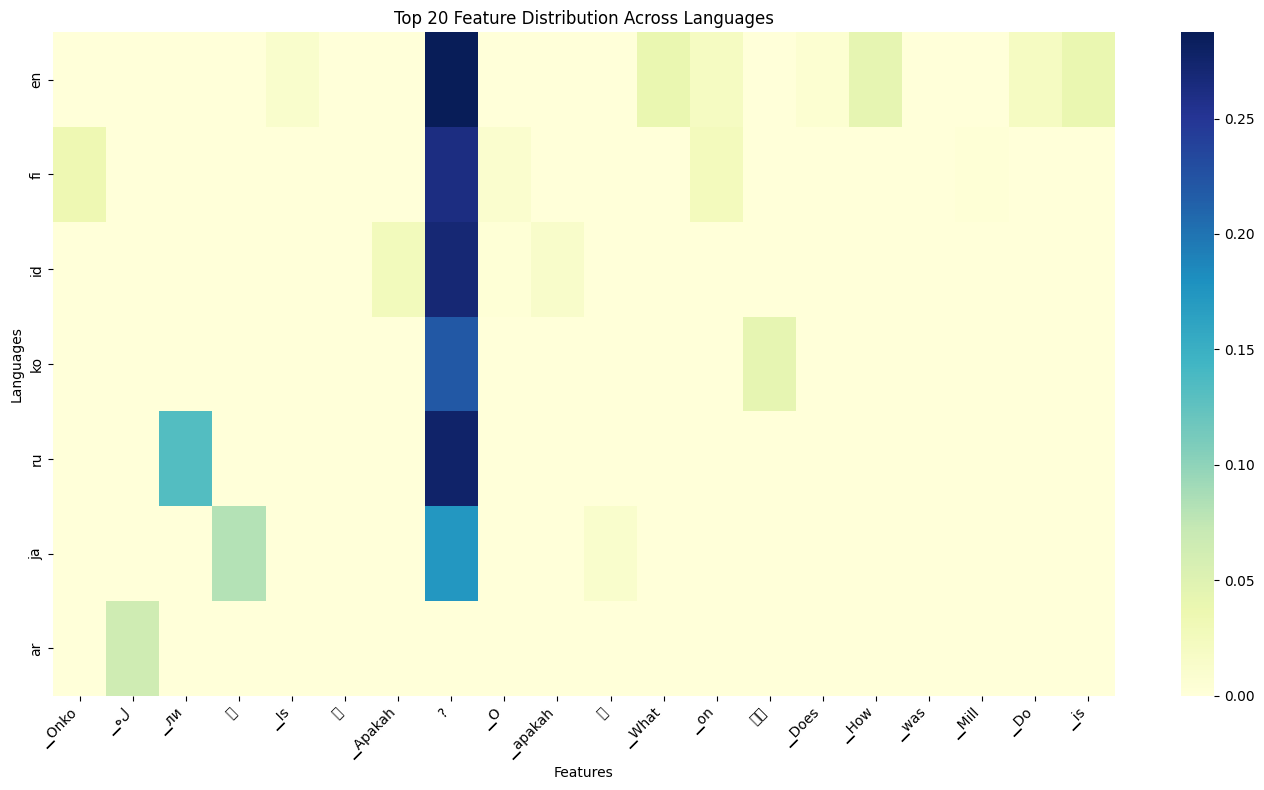

In [27]:
# ==================== Analyze feature importance patterns by language
def analyze_feature_distribution(language_results, languages_ordered):
    print("\nAnalyzing feature distribution across languages...")

    # Get language information
    language_data = dataset['test']['language']

    # Get top features from the baseline model
    feature_importance = xgb_clf.feature_importances_
    importance_df = pd.DataFrame({
        'feature_index': range(len(feature_importance)),
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    top_features = importance_df.head(20)['feature_index'].tolist()

    # Create index_to_token mapping
    index_to_token = {idx: token for token, idx in token_to_index.items()}

    # Get display names for top features
    top_feature_names = []
    for idx in top_features:
        token = index_to_token.get(idx, f"Unknown-{idx}")
        if isinstance(token, bytes):
            token = token.decode('utf-8', errors='replace')
        if len(str(token)) > 15:
            token = str(token)[:12] + "..."
        top_feature_names.append(str(token))

    # Choose top languages by sample size (limit to 10)
    top_languages = languages_ordered[:10]

    # Calculate feature presence for each language
    feature_presence = {}

    for lang in top_languages:
        # Create mask for this language
        lang_mask = [x == lang for x in language_data]
        lang_indices = [i for i, x in enumerate(lang_mask) if x]

        # Skip if not enough samples
        if len(lang_indices) < 10:
            continue

        # Get test data for this language
        X_test_lang = X_test_stacked[lang_indices]

        # Calculate average value for each top feature
        feature_values = []
        for idx in top_features:
            feature_col = X_test_lang[:, idx].toarray().flatten()
            avg_value = np.mean(feature_col)
            feature_values.append(avg_value)

        feature_presence[lang] = feature_values

    # Create heatmap of feature presence
    if feature_presence:
        plt.figure(figsize=(14, 8))

        # Prepare data for heatmap
        langs = list(feature_presence.keys())
        heatmap_data = [feature_presence[lang] for lang in langs]

        # Create heatmap
        ax = sns.heatmap(heatmap_data, cmap='YlGnBu',
                       xticklabels=top_feature_names,
                       yticklabels=langs)

        plt.title('Top 20 Feature Distribution Across Languages')
        plt.xlabel('Features')
        plt.ylabel('Languages')
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()

        # Log to wandb
        wandb.log({"feature_distribution": wandb.Image(plt)})

        # Calculate language performance impact
        language_impacts = []

        for lang in feature_presence:
            # Skip if no baseline or destroyed model data
            if (lang not in language_results or
                not any(seed in language_results[lang]['destroyed'] for seed in [1, 2, 3])):
                continue

            # Calculate impact
            baseline_acc = language_results[lang]['baseline']['accuracy']
            destroyed_accs = [
                language_results[lang]['destroyed'][seed]['accuracy']
                for seed in [1, 2, 3]
                if seed in language_results[lang]['destroyed']
            ]

            if destroyed_accs:
                avg_destroyed_acc = sum(destroyed_accs) / len(destroyed_accs)
                accuracy_drop = baseline_acc - avg_destroyed_acc

                # Simplified feature score (sum of feature values)
                feature_score = sum(feature_presence[lang])

                language_impacts.append([
                    lang,
                    language_results[lang]['samples'],
                    baseline_acc,
                    avg_destroyed_acc,
                    accuracy_drop,
                    feature_score
                ])

        # Log language impact table to wandb
        if language_impacts:
            wandb.log({
                "language_feature_impact": wandb.Table(
                    columns=["Language", "Samples", "Baseline Acc",
                            "Avg Destroyed Acc", "Accuracy Drop", "Feature Score"],
                    data=language_impacts
                )
            })



        print(f"Generated feature distribution heatmap for {len(feature_presence)} languages")
    else:
        print("Not enough language data to analyze feature distribution")

# Run the analysis
analyze_feature_distribution(language_results, languages_ordered)

In [28]:
wandb.finish()